# TIF360 Project

# Data Pre-processing

Main source: https://www.kaggle.com/code/rmonge/predicting-molecule-properties-based-on-its-smiles/notebook

### Import packages

In [1]:
import os
import rdkit
from rdkit import Chem  # To extract information of the molecules
from rdkit.Chem import Draw  # To draw the molecules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch_geometric
from torch_geometric.loader import DataLoader
import torch_geometric.utils as utils
import networkx as nx
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool, GraphConv, GATConv, GCNConv
import torch.nn.functional as F

from sklearn.metrics import r2_score

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define function to read xyz files

In [2]:
def read_xyz(path):
    """
    Reads the xyz files in the directory on 'path'
    Input
    path: the path to the folder to be read
    
    Output
    atoms: list with the characters representing the atoms of a molecule
    coordinates: list with the cartesian coordinates of each atom
    smile: list with the SMILE representation of a molecule
    prop: list with the scalar properties
    """
    atoms = []
    coordinates = []

    with open(path, 'r') as file:
        lines = file.readlines()
        n_atoms = int(lines[0])  # the number of atoms
        smile = lines[n_atoms + 3].split()[0]  # smiles string
        prop = lines[1].split()[2:]  # scalar properties

        # to retrieve each atmos and its cartesian coordenates
        for atom in lines[2:n_atoms + 2]:
            line = atom.split()
            # which atom
            atoms.append(line[0])

            # its coordinate
            # Some properties have '*^' indicading exponentiation 
            try:
                coordinates.append(
                    (float(line[1]),
                     float(line[2]),
                     float(line[3]))
                    )
            except:
                coordinates.append(
                    (float(line[1].replace('*^', 'e')),
                     float(line[2].replace('*^', 'e')),
                     float(line[3].replace('*^', 'e')))
                    )
                    
    return atoms, coordinates, smile, prop

### Read xyz files

In [3]:
directory = '../data/dsgdb9nsd.xyz/'

# Reads the xyz files and return the properties, smiles and coordinates
data = []
smiles = []
properties = []
for file in os.listdir(directory):
    path = os.path.join(directory, file)
    atoms, coordinates, smile, prop = read_xyz(path)
    data.append((atoms, coordinates)) # A tuple with the atoms and its coordinates 
    smiles.append(smile) # The SMILES representation
    properties.append(prop) # The molecules properties

properties_names = ['A', 'B', 'C', 'mu', 'alfa', 'homo', 'lumo', 'gap', 'R²', 'zpve', 'U0', 'U', 'H', 'G', 'Cv']
df = pd.DataFrame(properties, columns = properties_names).astype('float32')
df['smiles'] = smiles
df.head()

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles
0,157.711807,157.709976,157.706985,0.0000,13.210000,-0.3877,0.1171,0.5048,35.364101,0.044749,-40.478931,-40.476063,-40.475117,-40.498596,6.469,C
1,293.609741,293.541107,191.393967,1.6256,9.460000,-0.2570,0.0829,0.3399,26.156300,0.034358,-56.525887,-56.523026,-56.522083,-56.544960,6.316,N
2,799.588135,437.903870,282.945465,1.8511,6.310000,-0.2928,0.0687,0.3615,19.000200,0.021375,-76.404701,-76.401871,-76.400925,-76.422348,6.002,O
3,0.000000,35.610035,35.610035,0.0000,16.280001,-0.2845,0.0506,0.3351,59.524799,0.026841,-77.308426,-77.305527,-77.304581,-77.327431,8.574,C#C
4,0.000000,44.593884,44.593884,2.8937,12.990000,-0.3604,0.0191,0.3796,48.747601,0.016601,-93.411888,-93.409370,-93.408424,-93.431244,6.278,C#N


### Investigate how cordianets are specified

In [4]:
# Print cordinates of first molecule in data
print(data[0][1])

[(-0.0126981359, 1.0858041578, 0.0080009958), (0.002150416, -0.0060313176, 0.0019761204), (1.0117308433, 1.4637511618, 0.0002765748), (-0.540815069, 1.4475266138, -0.8766437152), (-0.5238136345, 1.4379326443, 0.9063972942)]


### Draw a few of the molecules

Number of NaNs:  0


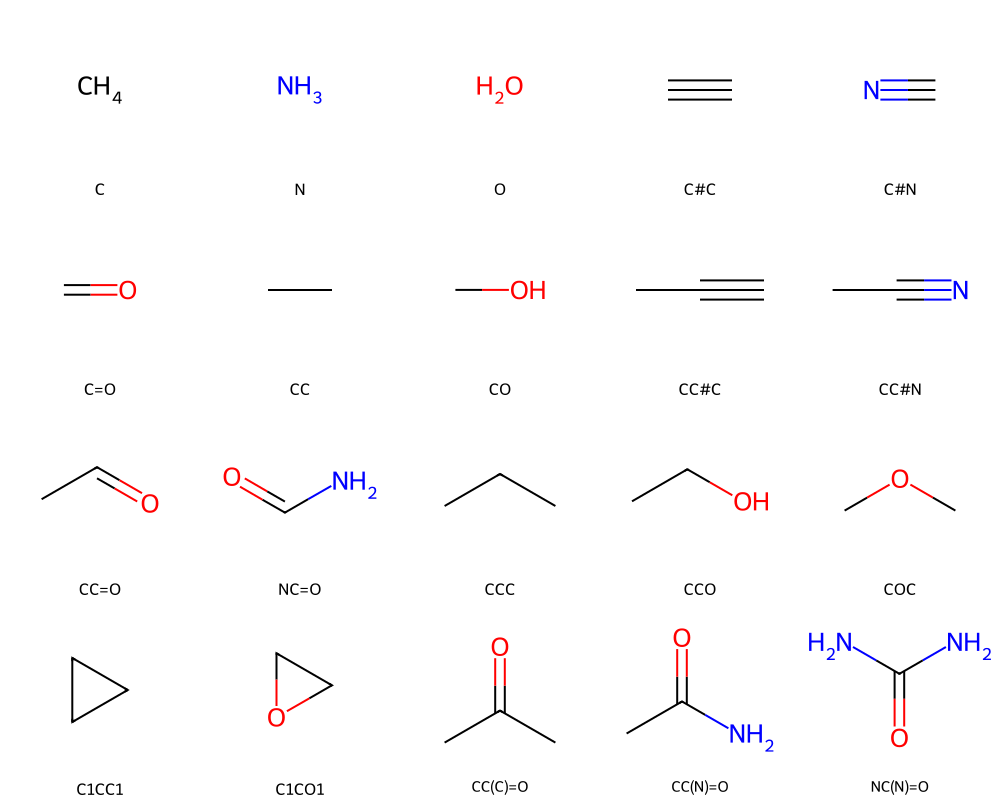

In [5]:
# Reading each molecule by its SMILES string
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

# Checking if there are None values
print("Number of NaNs: ", df['mol'].isnull().sum())

# Reads and prints the 20 first molecules
mol = df['mol'][:20]

Draw.MolsToGridImage(mol, molsPerRow=5, useSVG=True, legends=list(df['smiles'][:20].values))

### Add Hydrogens

In [6]:
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))

### Count the number of atoms and heavy atoms

In [7]:
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

df.head()

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles,mol,num_of_atoms,num_of_heavy_atoms
0,157.711807,157.709976,157.706985,0.0000,13.210000,-0.3877,0.1171,0.5048,35.364101,0.044749,-40.478931,-40.476063,-40.475117,-40.498596,6.469,C,<rdkit.Chem.rdchem.Mol object at 0x000001E044D...,5,1
1,293.609741,293.541107,191.393967,1.6256,9.460000,-0.2570,0.0829,0.3399,26.156300,0.034358,-56.525887,-56.523026,-56.522083,-56.544960,6.316,N,<rdkit.Chem.rdchem.Mol object at 0x000001E044D...,4,1
2,799.588135,437.903870,282.945465,1.8511,6.310000,-0.2928,0.0687,0.3615,19.000200,0.021375,-76.404701,-76.401871,-76.400925,-76.422348,6.002,O,<rdkit.Chem.rdchem.Mol object at 0x000001E044D...,3,1
3,0.000000,35.610035,35.610035,0.0000,16.280001,-0.2845,0.0506,0.3351,59.524799,0.026841,-77.308426,-77.305527,-77.304581,-77.327431,8.574,C#C,<rdkit.Chem.rdchem.Mol object at 0x000001E044D...,4,2
4,0.000000,44.593884,44.593884,2.8937,12.990000,-0.3604,0.0191,0.3796,48.747601,0.016601,-93.411888,-93.409370,-93.408424,-93.431244,6.278,C#N,<rdkit.Chem.rdchem.Mol object at 0x000001E044D...,3,2


### Make canonical SMILE

In [8]:
def canonize(mol):
    return Chem.MolToSmiles(Chem.MolFromSmiles(mol), isomericSmiles=True, canonical=True)

canon_smile = []
for molecule in smiles:
    canon_smile.append(canonize(molecule))
    
df['canon_smiles'] = canon_smile

df.head()

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles,mol,num_of_atoms,num_of_heavy_atoms,canon_smiles
0,157.711807,157.709976,157.706985,0.0000,13.210000,-0.3877,0.1171,0.5048,35.364101,0.044749,-40.478931,-40.476063,-40.475117,-40.498596,6.469,C,<rdkit.Chem.rdchem.Mol object at 0x000001E044D...,5,1,C
1,293.609741,293.541107,191.393967,1.6256,9.460000,-0.2570,0.0829,0.3399,26.156300,0.034358,-56.525887,-56.523026,-56.522083,-56.544960,6.316,N,<rdkit.Chem.rdchem.Mol object at 0x000001E044D...,4,1,N
2,799.588135,437.903870,282.945465,1.8511,6.310000,-0.2928,0.0687,0.3615,19.000200,0.021375,-76.404701,-76.401871,-76.400925,-76.422348,6.002,O,<rdkit.Chem.rdchem.Mol object at 0x000001E044D...,3,1,O
3,0.000000,35.610035,35.610035,0.0000,16.280001,-0.2845,0.0506,0.3351,59.524799,0.026841,-77.308426,-77.305527,-77.304581,-77.327431,8.574,C#C,<rdkit.Chem.rdchem.Mol object at 0x000001E044D...,4,2,C#C
4,0.000000,44.593884,44.593884,2.8937,12.990000,-0.3604,0.0191,0.3796,48.747601,0.016601,-93.411888,-93.409370,-93.408424,-93.431244,6.278,C#N,<rdkit.Chem.rdchem.Mol object at 0x000001E044D...,3,2,C#N


### Next we want to remove duplicates

In [9]:
print(df['canon_smiles'][df['canon_smiles'].duplicated()])

# Can see there are 87 duplicates
print("Number of rows: ", len(df['canon_smiles']))
# Drop duplicates:
ind = df.index[df['canon_smiles'].duplicated()]
df = df.drop(ind)
print("Number of rows: ", len(df['canon_smiles']))



936           Cc1cnccn1
945           Nc1cnccn1
955           Oc1cnccn1
4214          Fc1cnccn1
4576       Cc1cnc(N)cn1
              ...      
133327    Nc1c(F)cnnc1F
133363    Nc1nncc(F)c1N
133364    Nc1nncc(O)c1F
133365    Nc1nncc(F)c1O
133366    Nc1nncc(F)c1F
Name: canon_smiles, Length: 87, dtype: object
Number of rows:  133885
Number of rows:  133798


### Remake mol based on the canonical SMILEs

In [10]:
df['mol'] = df['canon_smiles'].apply(lambda x: Chem.MolFromSmiles(x))

### Investigate data and remove outliers

In [11]:
print(df.describe()) # A has very high std, need to investigate further



                   A              B              C             mu  \
count  133798.000000  133798.000000  133798.000000  133798.000000   
mean        9.817750       1.406112       1.124983       2.706031   
std      1810.053833       1.584265       1.095953       1.530345   
min         0.000000       0.337120       0.331180       0.000000   
25%         2.554310       1.091790       0.910563       1.588800   
50%         3.089935       1.370030       1.078720       2.500050   
75%         3.834450       1.653957       1.279640       3.635900   
max    619867.687500     437.903870     282.945465      29.556400   

                alfa           homo           lumo            gap  \
count  133798.000000  133798.000000  133798.000000  133798.000000   
mean       75.192818      -0.239977       0.011164       0.251141   
std         8.187229       0.022133       0.046923       0.047507   
min         6.310000      -0.428600      -0.175000       0.024600   
25%        70.379997      -0.2525

In [12]:

print(df[df['A'] > 100])

# Drop outliers
df = df.drop([483, 14561])

                   A           B           C      mu        alfa    homo  \
0         157.711807  157.709976  157.706985  0.0000   13.210000 -0.3877   
1         293.609741  293.541107  191.393967  1.6256    9.460000 -0.2570   
2         799.588135  437.903870  282.945465  1.8511    6.310000 -0.2928   
5         285.488403   38.982300   34.298920  2.1089   14.180000 -0.2670   
7         127.834969   24.858721   23.978720  1.5258   16.969999 -0.2653   
8         160.280411    8.593230    8.593210  0.7156   28.780001 -0.2609   
9         159.035675    9.223270    9.223240  3.8266   24.450001 -0.3264   
114       160.026535    2.048960    2.048960  1.1881   54.540001 -0.2420   
115       159.561462    2.076230    2.076230  5.1545   47.820000 -0.2871   
483    619867.687500    1.334550    1.334540  0.0151   72.389999 -0.2465   
2641      159.934586    0.783440    0.783440  1.5732   92.339996 -0.2323   
2642      159.619873    0.782570    0.782570  6.3203   82.739998 -0.2665   
14561  23266

In [13]:
print(df.describe()) # Problem solved

                   A              B              C             mu  \
count  133796.000000  133796.000000  133796.000000  133796.000000   
mean        3.446021       1.406119       1.124986       2.706072   
std         3.190802       1.584275       1.095960       1.530321   
min         0.000000       0.337120       0.331180       0.000000   
25%         2.554308       1.091790       0.910568       1.588800   
50%         3.089925       1.370030       1.078720       2.500100   
75%         3.834420       1.653962       1.279640       3.635925   
max       799.588135     437.903870     282.945465      29.556400   

                alfa           homo           lumo            gap  \
count  133796.000000  133796.000000  133796.000000  133796.000000   
mean       75.192528      -0.239977       0.011165       0.251142   
std         8.186394       0.022133       0.046923       0.047507   
min         6.310000      -0.428600      -0.175000       0.024600   
25%        70.379997      -0.2525

Download dataframe

In [40]:
df.to_csv("../data/smiles_and_targets.csv")

### Load data

In [4]:
import os
import rdkit
from rdkit import Chem  # To extract information of the molecules
from rdkit.Chem import Draw  # To draw the molecules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch_geometric
from torch_geometric.loader import DataLoader
import torch_geometric.utils as utils
import networkx as nx
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool, GraphConv, GATConv, GCNConv
import torch.nn.functional as F

from sklearn.metrics import r2_score

In [5]:
df = pd.read_csv("../data/smiles_and_targets.csv")

# Investigate Neural Networks

## Graph Neural Networks

#### Convert data to graphs

In [6]:
# import packages
from rdkit.Chem import GetAdjacencyMatrix
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

In [7]:
def one_hot_encoding(x, permitted_list):
    if x not in permitted_list:
        x = permitted_list[-1]  # If the atom is not in the list, get "Unknown"
        
    binary_encoding = [int(boolean) for boolean in list(map(lambda s: x==s, permitted_list))]
    
    return binary_encoding    

Atom featurisation\
Currently generates ca. 80 node features

In [8]:
def get_atom_features(atom, use_chirality = True, hydrogens_implicit = True):
    # list of permitted atoms
    permitted_atom_list = ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca',
                           'Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co',
                           'Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt',
                           'Hg','Pb','Unknown']
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_atom_list)
    
    n_heavy_neighbors = one_hot_encoding(int(atom.GetDegree()), [0,1,2,3,4,"MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, 'Extreme'])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_ring_enc = one_hot_encoding(int(atom.IsInRing()), [0, 1])
    
    is_aromatic_enc = one_hot_encoding(int(atom.GetIsAromatic()), [0, 1])
    
    atomic_mass_scaled = [float(atom.GetMass() - 10.812)/116.092] # (?) replace 10.812 with mean the and 116.092 with std
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)] # (?) replace 1.5 with mean the and 0.6 with std
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)] # (?) replace 0.64 with mean the and 0.76 with std
                              
    atom_feature_vector = atom_type_enc + n_heavy_neighbors + formal_charge_enc + hybridisation_type_enc + is_in_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
    
    if use_chirality:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
        
    if hydrogens_implicit:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc
        
    return np.array(atom_feature_vector) 

Bond Featurisation\
Currently generates ca. 10 edge features

In [9]:
def get_bond_features(bond, use_stereochemistry=True):
    permitted_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, 
                            Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
    
    bond_type_enc = one_hot_encoding(str(bond.GetBondType()), permitted_bond_types)
    
    bond_is_conjugated_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conjugated_enc + bond_is_in_ring_enc
    
    if use_stereochemistry:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc
        
    return np.array(bond_feature_vector)

Define function to generate dataset of labeled Pytorch Geometric Graphs

In [10]:
def create_graph_dataset_from_smiles(x_smiles, y):
    ## Inputs:
    # x_smiles = [smiles_1, smiles_2, ...], smiles representation of molecules
    # y = [y_1, y_2, ...] list of numerical labels for each smiles string, here chemical properties
    
    # Outputs:
    # dataset = [data_1, data_2, ...] list of torch_geometric.data.Data objects representing molecular graphs
    
    dataset = []
    
    for (smiles, y_val) in zip(x_smiles, y):
        # convert smiles to molecular object
        mol = Chem.MolFromSmiles(smiles)
        
        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds() # each bond is represented twice in the adjacency matrix
        n_node_features = len(get_atom_features(mol.GetAtomWithIdx(0)))
        if n_nodes > 1:
            n_edge_features = len(get_bond_features(mol.GetBondBetweenAtoms(0,1)))
        else:
            n_edge_features = 0  # for single atom molecules -> no edges
        
        # construct node feature matrix X 
        X = np.zeros((n_nodes, n_node_features))
        
        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)
        
        X = torch.tensor(X, dtype=torch.float)
        
        # construct edge index array E, shape = (2, n_edges)
        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        torch_rows = torch.tensor(rows.astype(np.int64)).to(torch.long)
        torch_cols = torch.tensor(cols.astype(np.int64)).to(torch.long)
        E = torch.stack([torch_rows, torch_cols], dim=0)
        
        # construct edge feature matrix EF
        EF = np.zeros((n_edges, n_edge_features))       # Note: generates zero matrix if n_edges = n_edge_features = 0
        for (k, (i,j)) in enumerate(zip(rows, cols)):
            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
        EF = torch.tensor(EF, dtype=torch.float)
        
        # construct label/y tensor
        y_tensor = torch.tensor(np.array([y_val]), dtype=torch.float)
        
        # construct torch_geometric.data.Data object and append to dataset
        dataset.append(Data(x=X, edge_index=E, edge_attr=EF, y=y_tensor))
        
    return dataset
        

We use the above functions to create a dataset of molecular graphs from the smiles and labels corresponding to chemical properties

In [11]:
properties_names = ['A', 'B', 'C', 'mu', 'alfa', 'homo', 'lumo', 'gap', 'R²', 'zpve', 'U0', 'U', 'H', 'G', 'Cv']

x_smiles = df.smiles.values
y = df.loc[:, properties_names].values  # shape = (n_samples, n_properties)

dataset = create_graph_dataset_from_smiles(x_smiles, y[0:len(x_smiles), :])

In [12]:
print(len(dataset))

# Example entries
print(df.smiles.values[0])
print(dataset[0])
print(df.smiles.values[2])
print(dataset[2])
print(df.smiles.values[50])
print(dataset[50])

print(dataset[50].edge_attr)
print(dataset[50].x)


133796
C
Data(x=[1, 81], edge_index=[2, 0], edge_attr=[0, 0], y=[1, 15])
O
Data(x=[1, 81], edge_index=[2, 0], edge_attr=[0, 0], y=[1, 15])
N1C=CN=C1
Data(x=[5, 81], edge_index=[2, 10], edge_attr=[10, 10], y=[1, 15])
tensor([[0., 0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0., 1.]])
tensor([[0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000,

Information of the graph dataset

In [13]:
print(f'Number of graphs (molecules): {len(dataset)}')
graph = dataset[50]
print('=================================================================================')
print(f'Properties of graph {50}, molecule smiles: {df.smiles.values[50]}')
print(f'Number of nodes: {dataset[50].x.shape[0]}')
print(f'Number of edges: {dataset[50].edge_index.shape[1]}')
print(f'Number of node features: {dataset[50].x.shape[1]}')
print(f'Number of edge features: {dataset[50].edge_attr.shape[1]}')
print(f'Number of properties: {dataset[50].y.shape[1]}')

Number of graphs (molecules): 133796
Properties of graph 50, molecule smiles: N1C=CN=C1
Number of nodes: 5
Number of edges: 10
Number of node features: 81
Number of edge features: 10
Number of properties: 15


Filterout data with no edge features defined (Like ex: CH4) (These causes problems down the line)

In [14]:


indexes_to_delete = []
for item in range(0,len(dataset)):
    if dataset[item].edge_attr.shape[1] == 0:
        indexes_to_delete.append(item)
    else:
        pass

indexes_to_delete.sort()

print("Number of none edge feature molecules: ", len(indexes_to_delete))

print("Before: ", len(dataset))

for item in range(0,len(indexes_to_delete)):
    print("Molecule to delete: ", df.smiles.values[indexes_to_delete[item]])
    #del dataset[indexes_to_delete[item] - item] 
    dataset.pop((indexes_to_delete[item] - item)) # -item since all future data points will have its index reduced by 1 for each deleted previous data point
print("After: ", len(dataset))

Number of none edge feature molecules:  3
Before:  133796
Molecule to delete:  C
Molecule to delete:  N
Molecule to delete:  O
After:  133793


Split data into train and test set

In [16]:
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler

# split the dataset into test and validation:
num_samples = len(dataset)

# Want to divide data randomly
random_indexes = np.array(random.sample(range(num_samples), num_samples)) # random.sample ensures no duplicates

train_data = [dataset[index] for index in random_indexes[int(.2 * num_samples ) :]] # 80%
test_data = [dataset[index] for index in random_indexes[: int(.2 * num_samples )]] # 20%

print("Example train data target before scaling", train_data[0].y)
train_data_targets = [data.y for data in train_data]
train_data_targets = torch.concatenate(train_data_targets, axis=0)
test_data_targets = [data.y for data in test_data]
test_data_targets = torch.concatenate(test_data_targets, axis=0)

scaler = StandardScaler()
train_data_targets = scaler.fit_transform(train_data_targets)
test_data_targets = scaler.transform(test_data_targets)

# print("Example train data target", train_data_targets[0].reshape(1,-1).shape)
train_data_targets = torch.tensor(train_data_targets, dtype=torch.float)
test_data_targets = torch.tensor(test_data_targets, dtype=torch.float)

train_data = [Data(x=data.x, edge_index=data.edge_index, edge_attr=data.edge_attr, y=train_data_targets[index].reshape(1,-1)) for index, data in enumerate(train_data)]
test_data = [Data(x=data.x, edge_index=data.edge_index, edge_attr=data.edge_attr, y=test_data_targets[index].reshape(1,-1)) for index, data in enumerate(test_data)]
print("Example train data target after scaling:", train_data[0].y)

print("Total data size: ", len(dataset))
print("Train data size: ", len(train_data))
print("Test data size: ", len(test_data))

#train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
#test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

Example train data target before scaling tensor([[ 4.1951e+00,  1.0351e+00,  8.4142e-01,  4.8002e+00,  7.0990e+01,
         -2.4190e-01, -1.0840e-01,  1.3350e-01,  1.2940e+03,  1.1266e-01,
         -4.5397e+02, -4.5396e+02, -4.5396e+02, -4.5400e+02,  2.9009e+01]])
Example train data target after scaling: tensor([[ 0.3335, -0.6987, -0.6929,  1.3647, -0.5112, -0.0853, -2.5439, -2.4745,
          0.3712, -1.0770, -1.0578, -1.0578, -1.0578, -1.0578, -0.6363]])
Total data size:  133793
Train data size:  107035
Test data size:  26758


Molecular descriptors

(Don't need to run this code anymore)

In [17]:
# calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])

# mol_descriptor = np.zeros(shape=(len(dataset), len([x[0] for x in Descriptors._descList])))

# counter = -1
# for molecule in df.smiles.values:
#     counter += 1
#     print("Iteration: ", counter)
#     mol_descriptor[counter,:] = calc.CalcDescriptors(Chem.MolFromSmiles(df.smiles.values[1000]))

# print(df.smiles.values[1000])
# print(mol_descriptor[1000,:])
# descriptors_list = [x[0] for x in Descriptors._descList]
# print(descriptors_list)

Download descriptors

In [18]:
# np.save("../data/mol_descriptors.npy", mol_descriptor)

### Load descriptors

In [20]:
mol_descriptor = np.load("../data/mol_descriptors.npy")

Divide descriptors into train and test

In [21]:
train_data_descriptor = [mol_descriptor[index,:] for index in random_indexes[int(.2 * num_samples ) :]] # 80%
test_data_desriptors = [mol_descriptor[index,:] for index in random_indexes[: int(.2 * num_samples )]] # 20%

Normalize using MinMax

In [22]:
minmax_scaler = StandardScaler()

train_data_descriptor = minmax_scaler.fit_transform(train_data_descriptor)

test_data_desriptors = minmax_scaler.transform(test_data_desriptors)

c:\Users\jespe\anaconda3\envs\proj_env\lib\site-packages\sklearn\preprocessing\_data.py:967: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


Combine descriptors temporarely with in train and test data for graphs

In [23]:
#Testing stuff

temp = train_data[1000]
temp.descriptors = train_data_descriptor[1000,:]

print(temp)

Data(x=[9, 81], edge_index=[2, 18], edge_attr=[18, 10], y=[1, 15], descriptors=[208])


In [24]:

for index in range(0,len(train_data)):
    train_data[index].descriptors = torch.FloatTensor([train_data_descriptor[index,:]])

for index in range(0,len(test_data)):
    test_data[index].descriptors = torch.FloatTensor([test_data_desriptors[index,:]])

# Example
print(train_data[0])

C:\Users\jespe\AppData\Local\Temp\ipykernel_648\2381591684.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  train_data[index].descriptors = torch.FloatTensor([train_data_descriptor[index,:]])


Data(x=[9, 81], edge_index=[2, 18], edge_attr=[18, 10], y=[1, 15], descriptors=[1, 208])


Use dataloader

In [25]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

### Main GNN

#### Model for all targets at once

GNN function

In [26]:
data_labels = dataset[50].y.shape[1]
data_features = dataset[50].x.shape[1]

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(data_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        self.conv4 = GATConv(hidden_channels, hidden_channels)
        self.conv5 = GATConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels+208, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, data_labels)

    def forward(self, x, edge_index, edge_attr, batch, descriptors): 
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv3(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv4(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv5(x, edge_index, edge_attr)

        #Returns batch-wise graph-level-outputs by averaging node features across the node dimension, so that for a single graph G
        #its output is computed by
        x = global_mean_pool(x, batch) 
        x2 = descriptors
        x = torch.cat((x,x2),1)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(x)
        x = self.lin3(x)
        
 
        return x
    

Train GNN

In [27]:
model = GNN(hidden_channels=128) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

def train(data_in):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data_in.x, data_in.edge_index, data_in.edge_attr, data_in.batch, data_in.descriptors)  # Perform a single forward pass.

      #Alt 1
      loss = criterion(out, data_in.y) 

      #Alt 2
      #loss = 0
      #for item in range(0,len(data_in.y[0,:])):
      #      loss += criterion(out[:,item], data_in.y[:,item]) 

      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(data):
      all_test_r2 = []
      counter = -1    
      for data_in in data:
            counter += 1
            model.eval()
            out = model(data_in.x, data_in.edge_index, data_in.edge_attr, data_in.batch, data_in.descriptors)

            # Caculate R2
            r2_score_var = []
            for item in range(0,data_in.y.shape[1]):
                  if item == 0:
                        r2_score_var = r2_score(data_in.y[:,item].detach().numpy(), out[:,item].detach().numpy())
                  else:
                        r2_score_var = np.vstack((r2_score_var,(r2_score(data_in.y[:,item].detach().numpy(), out[:,item].detach().numpy()))))

            if counter == 0:
                  all_test_r2 = r2_score_var
            else:
                  all_test_r2 = np.hstack((all_test_r2,r2_score_var))

      average_test_r2 = np.sum(all_test_r2,axis=1) / all_test_r2.shape[1]

      return average_test_r2

# Vectors to append accuracy to:
Train_r2 = []
Test_r2 = []

# Calculate accuracy before training 
Train_r2.append(test(train_loader))
Test_r2.append(test(test_loader))
print("Initial training R2: ", Train_r2[0])
print("Initial test R2: ", Test_r2[0])

print_r2_option = True
for epoch in range(1, 101):
      average_loss = []
      for data in train_loader:
            loss = train(data)
            average_loss.append(loss)
      print(f'Epoch: {epoch:03d}, Loss: {(sum(average_loss)/len(average_loss)):.4f}')

      if print_r2_option:

            temp_train_r2 = test(train_loader)
            Train_r2.append(temp_train_r2)

            temp_test_r2 = test(test_loader)
            Test_r2.append(temp_test_r2)

            print(f'Average Train R2: {temp_train_r2}')
            print(f'Average Test R2: {temp_test_r2:}')

Initial training R2:  [-0.02094812 -0.01727923 -0.01868568 -0.02063815 -0.02694835 -0.01591444
 -0.01742936 -0.01564284 -0.01816109 -0.02272958 -0.02615592 -0.01652956
 -0.01647908 -0.0228493  -0.02437223]
Initial test R2:  [-0.02424917 -0.01805008 -0.02021459 -0.01948052 -0.0377332  -0.01620845
 -0.02201152 -0.02007317 -0.02201043 -0.03212286 -0.02892101 -0.01787317
 -0.01796902 -0.02533834 -0.02840574]
Epoch: 001, Loss: 0.5557
Average Train R2: [0.15015818 0.40754613 0.48393407 0.28256844 0.60104484 0.20647579
 0.70654727 0.66576725 0.61356203 0.81248868 0.62782877 0.62859955
 0.62851548 0.62823566 0.62696804]
Average Test R2: [0.12046047 0.39682655 0.47323106 0.28624877 0.61949045 0.19373181
 0.70202582 0.66211177 0.60609961 0.81836102 0.62456136 0.6253828
 0.62527946 0.62494003 0.63503955]
Epoch: 002, Loss: 0.4755
Average Train R2: [0.14994092 0.44362892 0.5147335  0.28821069 0.62719232 0.47783914
 0.74686955 0.74116827 0.67330381 0.87278082 0.68484479 0.68428107
 0.68463007 0.6847

KeyboardInterrupt: 

#### Model for just one target

GNN function

In [28]:
data_labels = 1
data_features = dataset[50].x.shape[1]

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(data_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        self.conv4 = GATConv(hidden_channels, hidden_channels)
        self.conv5 = GATConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels+208, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, data_labels)

    def forward(self, x, edge_index, edge_attr, batch, descriptors): 
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv3(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv4(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv5(x, edge_index, edge_attr)

        #Returns batch-wise graph-level-outputs by averaging node features across the node dimension, so that for a single graph G
        #its output is computed by
        x = global_mean_pool(x, batch) 
        x2 = descriptors
        x = torch.cat((x,x2),1)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(x)
        x = self.lin3(x)
        
 
        return x
    

Train GNN

In [29]:
model = GNN(hidden_channels=64) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

def train(data_in):
      target = 6 # target index of interest
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data_in.x, data_in.edge_index, data_in.edge_attr, data_in.batch, data_in.descriptors)  # Perform a single forward pass.

      loss = criterion(out, data_in.y[:,target])  

      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(data):
      target = 6 # target index of interest
      all_test_r2 = []  
      for data_in in data:
            model.eval()
            out = model(data_in.x, data_in.edge_index, data_in.edge_attr, data_in.batch, data_in.descriptors)

            # Caculate R2
            r2_score_var = r2_score(data_in.y[:,target].detach().numpy(), out.detach().numpy())

            all_test_r2 .append(r2_score_var)

      average_test_r2 = np.sum(all_test_r2) / len(all_test_r2)

      return average_test_r2

# Vectors to append accuracy to:
Train_r2 = []
Test_r2 = []

# Calculate accuracy before training 
Train_r2.append(test(train_loader))
Test_r2.append(test(test_loader))
print("Initial training R2: ", Train_r2[0])
print("Initial test R2: ", Test_r2[0])

print_r2_option = True
for epoch in range(1, 101):
      average_loss = []
      for data in train_loader:
            loss = train(data)
            average_loss.append(loss)
      print(f'Epoch: {epoch:03d}, Loss: {(sum(average_loss)/len(average_loss)):.4f}')

      if print_r2_option:

            temp_train_r2 = test(train_loader)
            Train_r2.append(temp_train_r2)

            temp_test_r2 = test(test_loader)
            Test_r2.append(temp_test_r2)

            print(f'Average Train R2: {temp_train_r2}')
            print(f'Average Test R2: {temp_test_r2:}')

Initial training R2:  -0.015837640958402236
Initial test R2:  -0.01562814564283641


c:\Users\jespe\anaconda3\envs\proj_env\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jespe\anaconda3\envs\proj_env\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001, Loss: 1.0004


KeyboardInterrupt: 

## Transformer